In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib

# Scikit-learn imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, partial_dependence

# SHAP for model interpretation
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: SHAP not available. Install with: pip install shap")

# Scipy for statistical plots
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


c:\Users\Mustafa Husain\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ==================== DATA LOADING & CLEANING ====================
print("\n[1] Loading and cleaning data...")

# Load the dataset
df = pd.read_csv('../clean_dbt_district_wise.csv')
print(f"   Original shape: {df.shape}")

# Handle missing values
df = df.dropna(subset=['transfer_per_transaction'])
print(f"   After removing NaN in target: {df.shape}")

# Remove outliers using IQR method for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"   After outlier removal: {df.shape}")


[1] Loading and cleaning data...
   Original shape: (3825, 9)
   After removing NaN in target: (3809, 9)
   After outlier removal: (3647, 9)


In [4]:
# ==================== FEATURE ENGINEERING ====================
print("\n[2] Feature engineering...")

# Create additional features
df['total_dbt_transfer_millions'] = df['total_dbt_transfer'] / 1_000_000
df['transactions_thousands'] = df['no_of_dbt_transactions'] / 1_000
df['year_duration'] = df['end_year'] - df['start_year']

# Encode categorical variables
label_encoders = {}
categorical_cols = ['state_name', 'district_name', 'fy']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print(f"   Encoded {len(categorical_cols)} categorical columns")



[2] Feature engineering...
   Encoded 3 categorical columns


In [5]:
# ==================== MODEL 1: LINEAR REGRESSION ====================
print("\n" + "=" * 70)
print("MODEL 1: LINEAR REGRESSION - Predicting Total DBT Transfer Amount")
print("=" * 70)

# Prepare features and target for Model 1
feature_cols_m1 = ['state_name_encoded', 'district_name_encoded', 'fy_encoded',
                   'no_of_dbt_transactions', 'start_year', 'end_year',
                   'transfer_per_transaction']

X_m1 = df[feature_cols_m1].copy()
y_m1 = df['total_dbt_transfer']

# Split data
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(
    X_m1, y_m1, test_size=0.2, random_state=42
)

# Scale features
scaler_m1 = StandardScaler()
X_train_m1_scaled = scaler_m1.fit_transform(X_train_m1)
X_test_m1_scaled = scaler_m1.transform(X_test_m1)

# Train model
model_m1 = LinearRegression()
model_m1.fit(X_train_m1_scaled, y_train_m1)

# Predictions
y_pred_train_m1 = model_m1.predict(X_train_m1_scaled)
y_pred_test_m1 = model_m1.predict(X_test_m1_scaled)

# Evaluate
mae_m1 = mean_absolute_error(y_test_m1, y_pred_test_m1)
rmse_m1 = np.sqrt(mean_squared_error(y_test_m1, y_pred_test_m1))
r2_m1 = r2_score(y_test_m1, y_pred_test_m1)

print(f"\nModel 1 Performance:")
print(f"   MAE:  {mae_m1:,.2f}")
print(f"   RMSE: {rmse_m1:,.2f}")
print(f"   R²:   {r2_m1:.4f}")

# Save model
joblib.dump(model_m1, '../Models/model1_linear_regression.pkl')
joblib.dump(scaler_m1, '../Models/scaler_model1.pkl')
print("   Model saved to Models/model1_linear_regression.pkl")


MODEL 1: LINEAR REGRESSION - Predicting Total DBT Transfer Amount

Model 1 Performance:
   MAE:  1,451,092,690.06
   RMSE: 2,244,498,275.13
   R²:   0.8534
   Model saved to Models/model1_linear_regression.pkl



[3] Generating Model 1 visualizations...


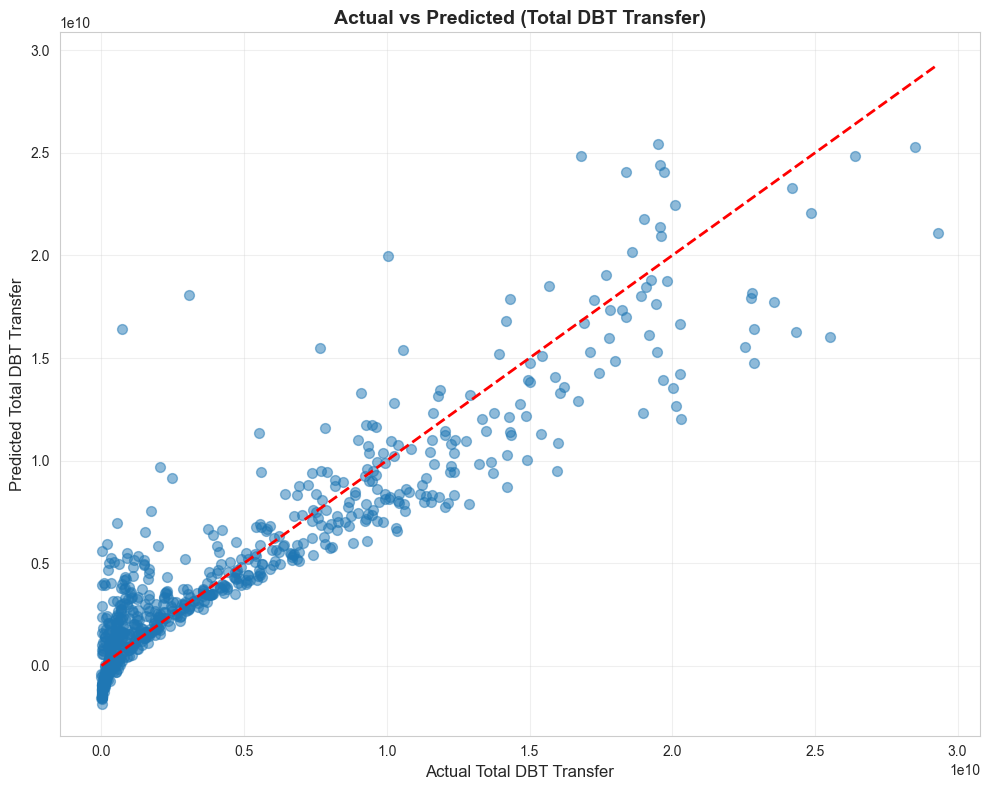

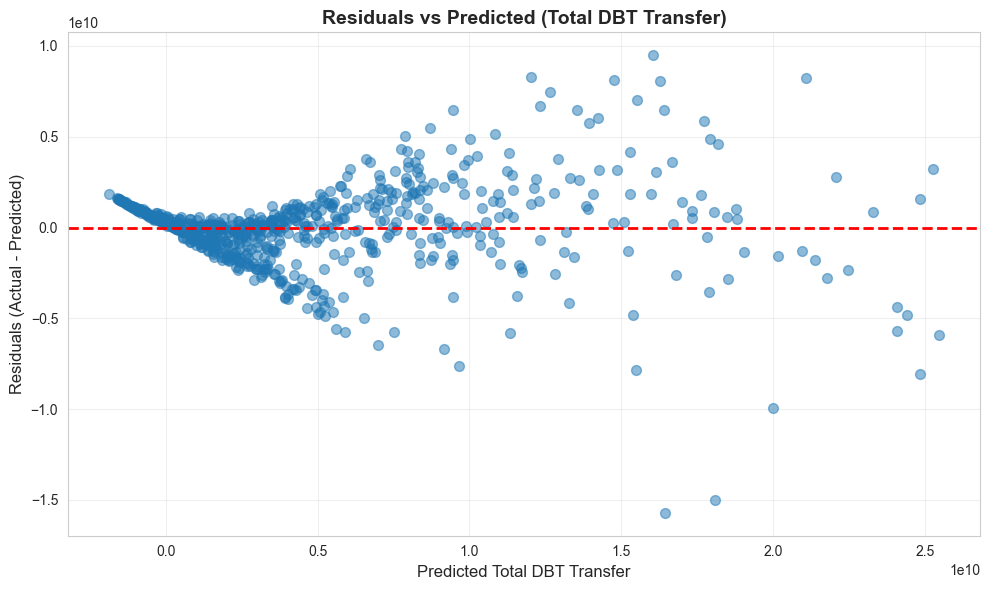

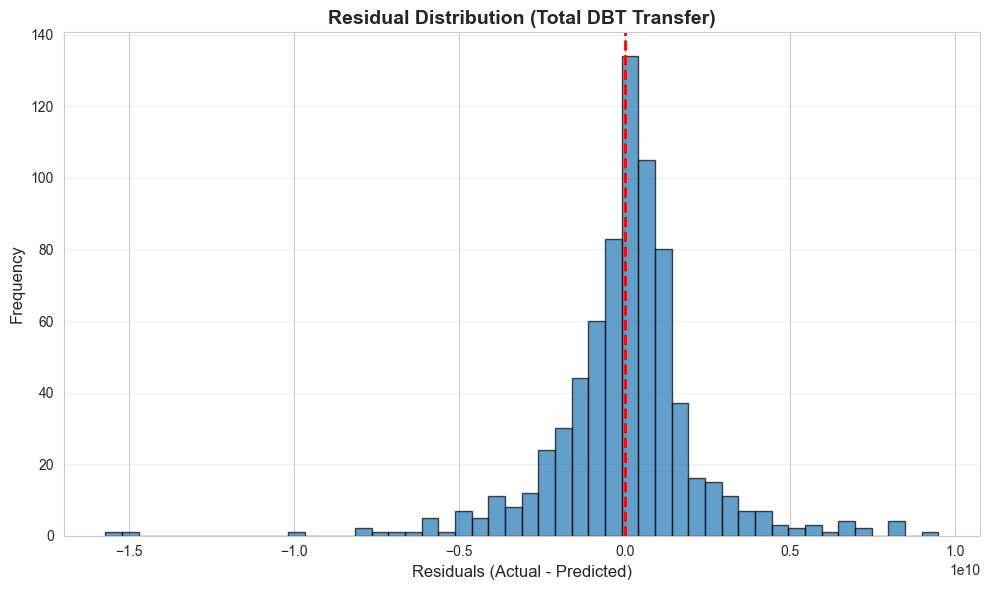

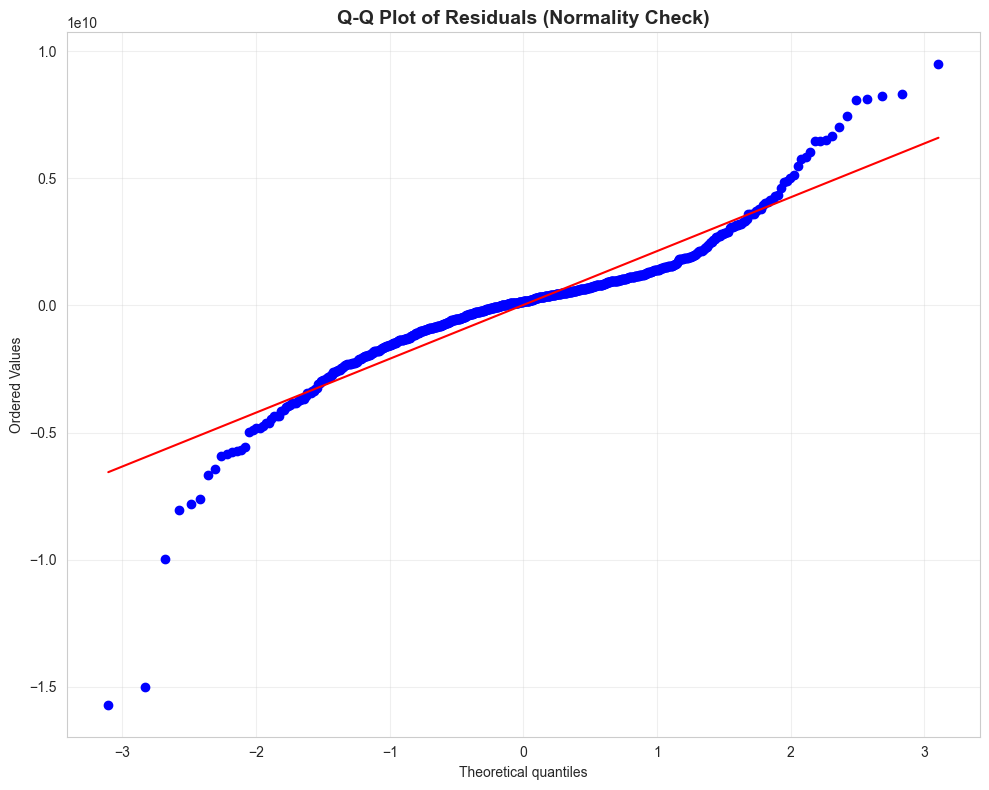

   5 visualizations saved for Model 1


In [7]:
# ==================== MODEL 1 VISUALIZATIONS ====================
print("\n[3] Generating Model 1 visualizations...")

# 1. Actual vs Predicted Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test_m1, y_pred_test_m1, alpha=0.5, s=50)
ax.plot([y_test_m1.min(), y_test_m1.max()], 
        [y_test_m1.min(), y_test_m1.max()], 'r--', lw=2)
ax.set_xlabel('Actual Total DBT Transfer', fontsize=12)
ax.set_ylabel('Predicted Total DBT Transfer', fontsize=12)
ax.set_title('Actual vs Predicted (Total DBT Transfer)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals_m1 = y_test_m1 - y_pred_test_m1
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_pred_test_m1, residuals_m1, alpha=0.5, s=50)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Predicted Total DBT Transfer', fontsize=12)
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Residuals vs Predicted (Total DBT Transfer)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Residual Distribution Histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(residuals_m1, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Residual Distribution (Total DBT Transfer)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 4. Coefficient Impact Bar Chart
coefficients_m1 = pd.DataFrame({
    'Feature': feature_cols_m1,
    'Coefficient': model_m1.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in coefficients_m1['Coefficient']]
ax.barh(coefficients_m1['Feature'], coefficients_m1['Coefficient'], color=colors, alpha=0.7)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Feature Coefficients Impact on Total DBT Transfer', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', lw=1)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.close()

# 5. QQ Plot
fig, ax = plt.subplots(figsize=(10, 8))
stats.probplot(residuals_m1, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals (Normality Check)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("   5 visualizations saved for Model 1")

In [8]:
# ==================== MODEL 2: RANDOM FOREST ====================
print("\n" + "=" * 70)
print("MODEL 2: RANDOM FOREST - Predicting Average Benefit Per Person")
print("=" * 70)

# Prepare features and target for Model 2
feature_cols_m2 = ['state_name_encoded', 'district_name_encoded', 'fy_encoded',
                   'total_dbt_transfer', 'no_of_dbt_transactions', 
                   'start_year', 'end_year']

X_m2 = df[feature_cols_m2].copy()
y_m2 = df['transfer_per_transaction']

# Split data
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(
    X_m2, y_m2, test_size=0.2, random_state=42
)

# Train model (no scaling needed for tree-based models)
model_m2 = RandomForestRegressor(n_estimators=100, max_depth=15, 
                                  random_state=42, n_jobs=-1)
model_m2.fit(X_train_m2, y_train_m2)

# Predictions
y_pred_train_m2 = model_m2.predict(X_train_m2)
y_pred_test_m2 = model_m2.predict(X_test_m2)

# Evaluate
mae_m2 = mean_absolute_error(y_test_m2, y_pred_test_m2)
rmse_m2 = np.sqrt(mean_squared_error(y_test_m2, y_pred_test_m2))
r2_m2 = r2_score(y_test_m2, y_pred_test_m2)

print(f"\nModel 2 Performance:")
print(f"   MAE:  {mae_m2:.2f}")
print(f"   RMSE: {rmse_m2:.2f}")
print(f"   R²:   {r2_m2:.4f}")

# Save model
joblib.dump(model_m2, '../Models/model2_random_forest.pkl')
print("   Model saved to models/model2_random_forest.pkl")


MODEL 2: RANDOM FOREST - Predicting Average Benefit Per Person

Model 2 Performance:
   MAE:  64.33
   RMSE: 192.20
   R²:   0.9408
   Model saved to models/model2_random_forest.pkl

Model 2 Performance:
   MAE:  64.33
   RMSE: 192.20
   R²:   0.9408
   Model saved to models/model2_random_forest.pkl



[4] Generating Model 2 visualizations...


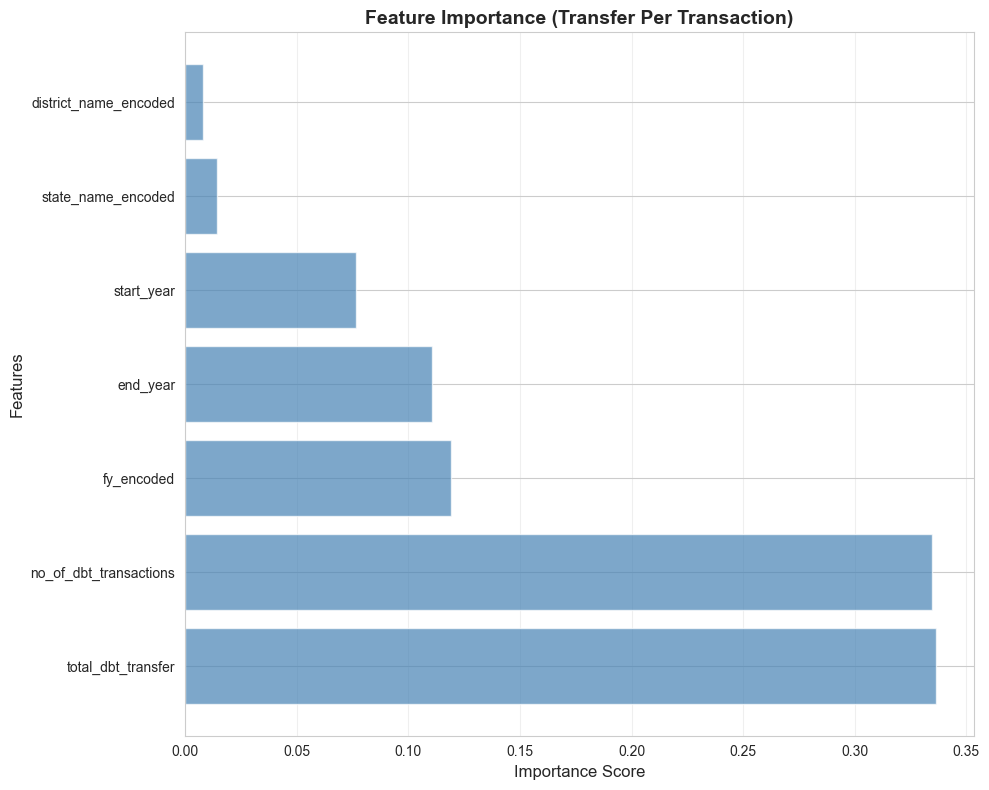

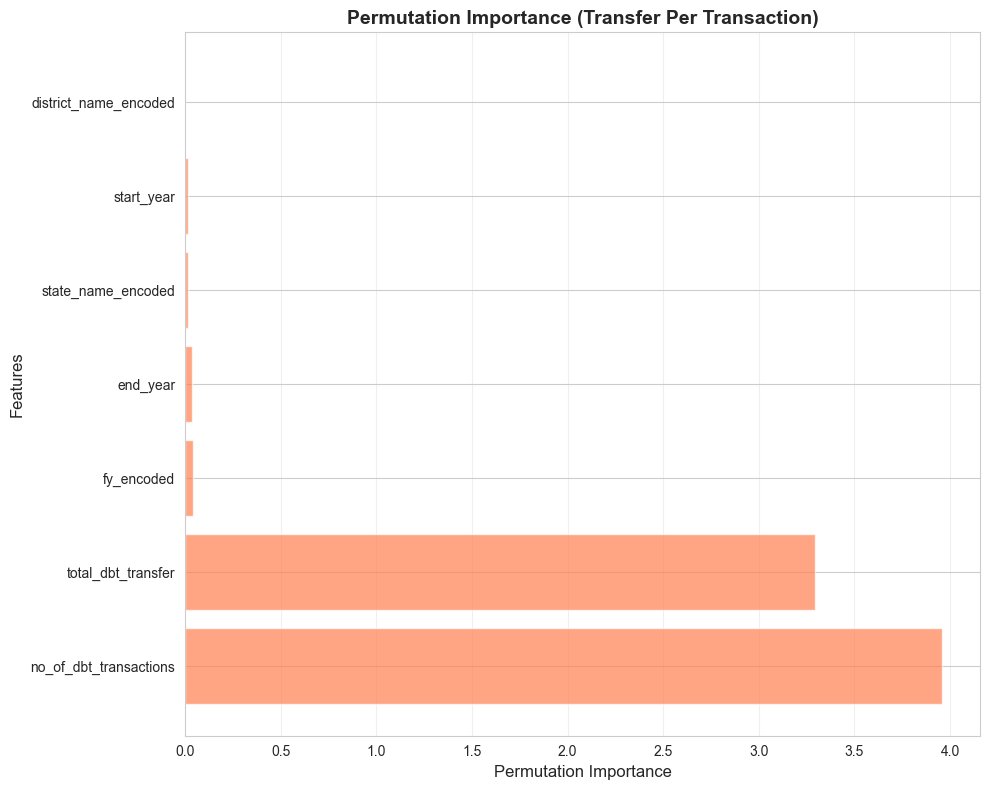

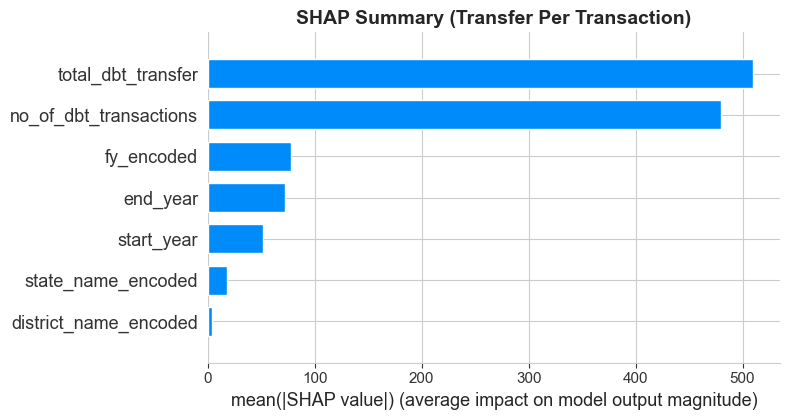

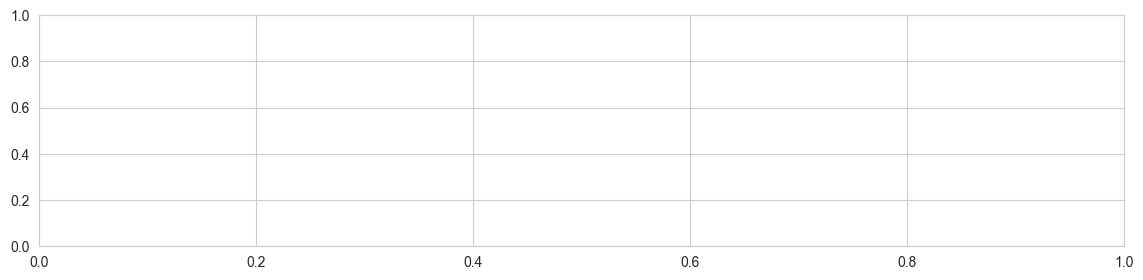

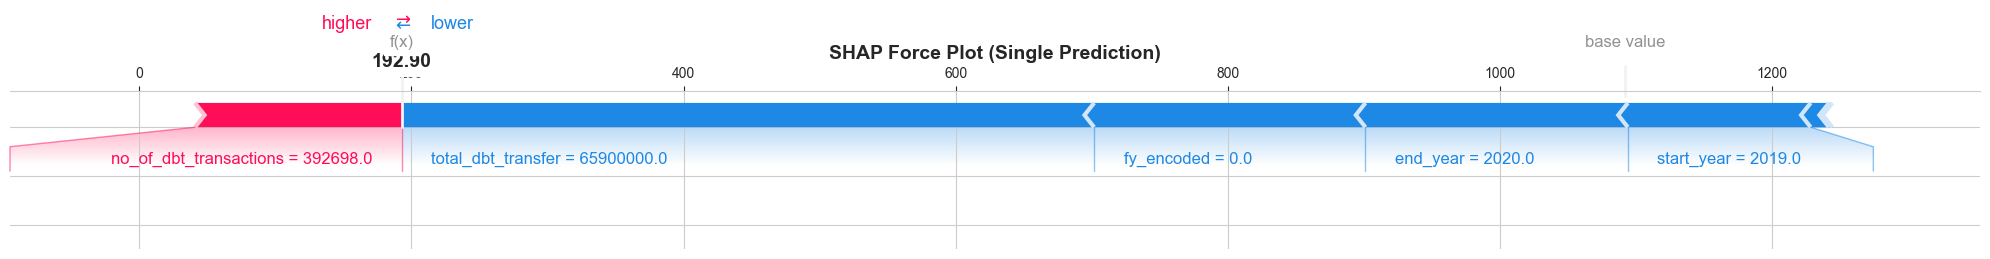

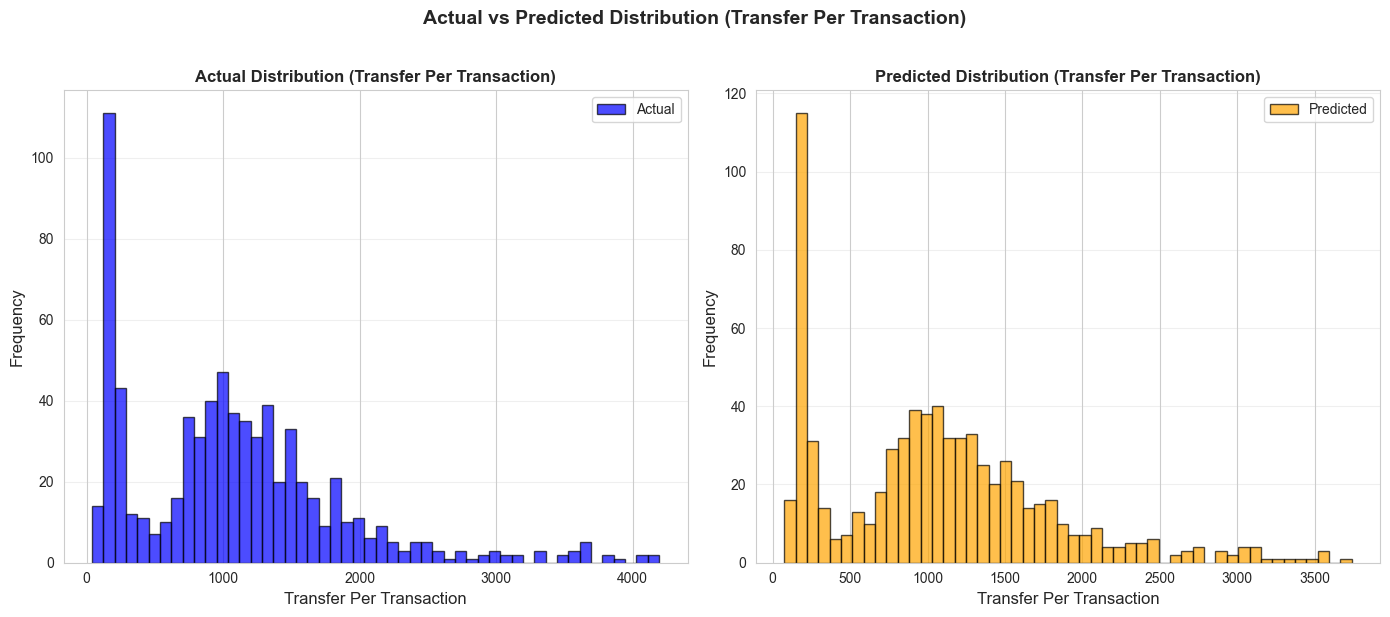

   5 visualizations saved for Model 2


In [9]:
# ==================== MODEL 2 VISUALIZATIONS ====================
print("\n[4] Generating Model 2 visualizations...")

# 1. Feature Importance Plot
feature_importance_m2 = pd.DataFrame({
    'Feature': feature_cols_m2,
    'Importance': model_m2.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_importance_m2['Feature'], feature_importance_m2['Importance'], 
        color='steelblue', alpha=0.7)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Feature Importance (Transfer Per Transaction)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 2. Permutation Importance Plot
perm_importance = permutation_importance(model_m2, X_test_m2, y_test_m2, 
                                         n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': feature_cols_m2,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], 
        color='coral', alpha=0.7)
ax.set_xlabel('Permutation Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Permutation Importance (Transfer Per Transaction)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 3. SHAP Summary Plot (if available)
if SHAP_AVAILABLE:
    try:
        # Sample data for faster SHAP computation
        X_sample = X_test_m2.sample(min(500, len(X_test_m2)), random_state=42)
        explainer = shap.TreeExplainer(model_m2)
        shap_values = explainer.shap_values(X_sample)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_cols_m2, 
                         show=False, plot_type='bar')
        plt.title('SHAP Summary (Transfer Per Transaction)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   Warning: Could not generate SHAP plot: {e}")

# 4. SHAP Force Plot for Random Sample
if SHAP_AVAILABLE:
    try:
        random_idx = X_test_m2.sample(1, random_state=42).index[0]
        shap_values_single = explainer.shap_values(X_test_m2.loc[[random_idx]])
        
        fig, ax = plt.subplots(figsize=(14, 3))
        shap.force_plot(explainer.expected_value, shap_values_single[0], 
                       X_test_m2.loc[random_idx], feature_names=feature_cols_m2,
                       matplotlib=True, show=False)
        plt.title('SHAP Force Plot (Single Prediction)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   Warning: Could not generate SHAP force plot: {e}")

# 5. Actual vs Predicted Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(y_test_m2, bins=50, alpha=0.7, label='Actual', color='blue', edgecolor='black')
axes[0].set_xlabel('Transfer Per Transaction', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Actual Distribution (Transfer Per Transaction)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(y_pred_test_m2, bins=50, alpha=0.7, label='Predicted', color='orange', edgecolor='black')
axes[1].set_xlabel('Transfer Per Transaction', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Predicted Distribution (Transfer Per Transaction)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Actual vs Predicted Distribution (Transfer Per Transaction)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("   5 visualizations saved for Model 2")

In [10]:
# ==================== MODEL 3: GRADIENT BOOSTING ====================
print("\n" + "=" * 70)
print("MODEL 3: GRADIENT BOOSTING - Predicting Number of Beneficiaries")
print("=" * 70)

# Prepare features and target for Model 3
feature_cols_m3 = ['state_name_encoded', 'district_name_encoded', 'fy_encoded',
                   'total_dbt_transfer', 'start_year', 'end_year',
                   'transfer_per_transaction']

X_m3 = df[feature_cols_m3].copy()
y_m3 = df['no_of_dbt_transactions']

# Split data
X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(
    X_m3, y_m3, test_size=0.2, random_state=42
)

# Train model
model_m3 = GradientBoostingRegressor(n_estimators=100, max_depth=5, 
                                      learning_rate=0.1, random_state=42)
model_m3.fit(X_train_m3, y_train_m3)

# Predictions
y_pred_train_m3 = model_m3.predict(X_train_m3)
y_pred_test_m3 = model_m3.predict(X_test_m3)

# Evaluate
mae_m3 = mean_absolute_error(y_test_m3, y_pred_test_m3)
rmse_m3 = np.sqrt(mean_squared_error(y_test_m3, y_pred_test_m3))
r2_m3 = r2_score(y_test_m3, y_pred_test_m3)

print(f"\nModel 3 Performance:")
print(f"   MAE:  {mae_m3:,.2f}")
print(f"   RMSE: {rmse_m3:,.2f}")
print(f"   R²:   {r2_m3:.4f}")

# Save model
joblib.dump(model_m3, '../Models/model3_gradient_boosting.pkl')
print("   Model saved to models/model3_gradient_boosting.pkl")


MODEL 3: GRADIENT BOOSTING - Predicting Number of Beneficiaries

Model 3 Performance:
   MAE:  166,625.28
   RMSE: 393,634.89
   R²:   0.9951
   Model saved to models/model3_gradient_boosting.pkl

Model 3 Performance:
   MAE:  166,625.28
   RMSE: 393,634.89
   R²:   0.9951
   Model saved to models/model3_gradient_boosting.pkl



[5] Generating Model 3 visualizations...


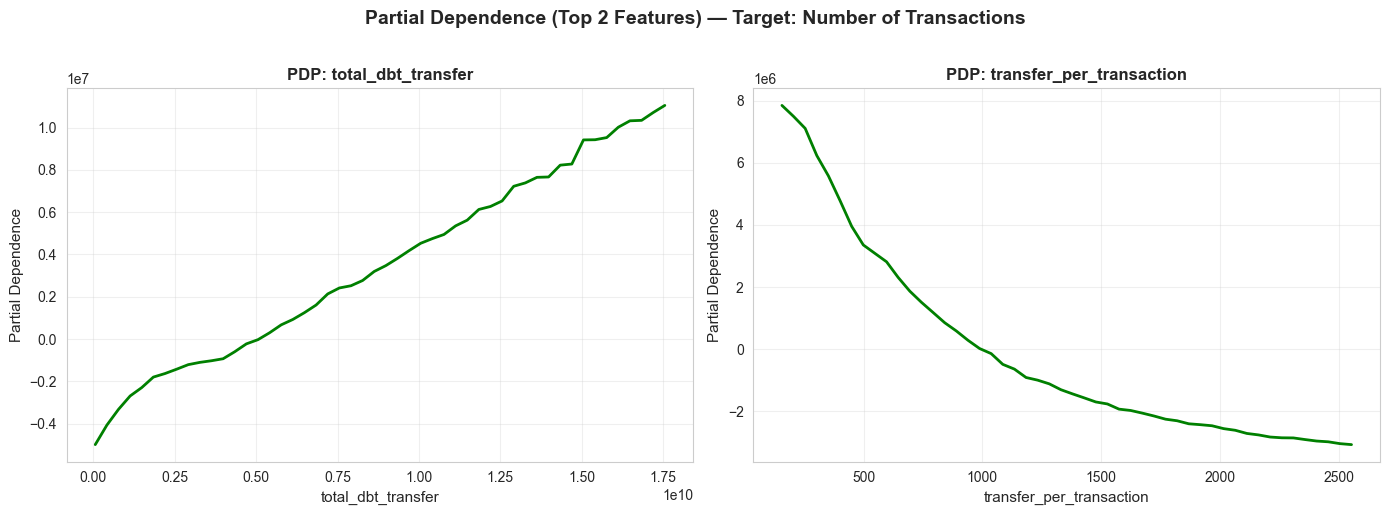

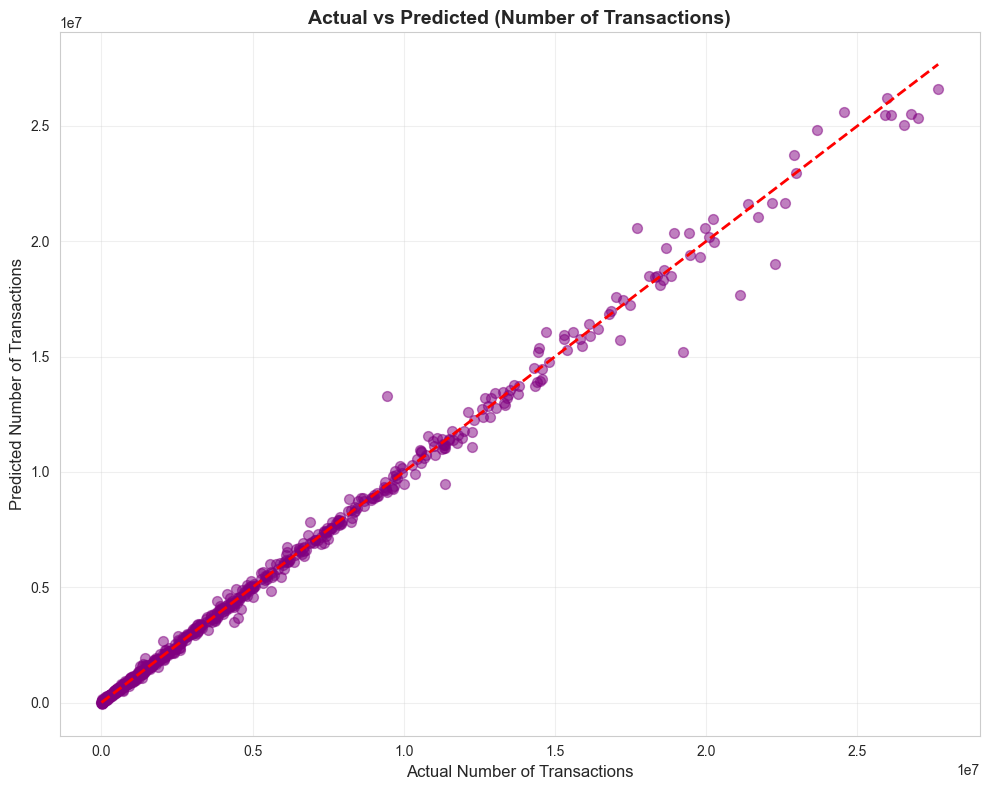

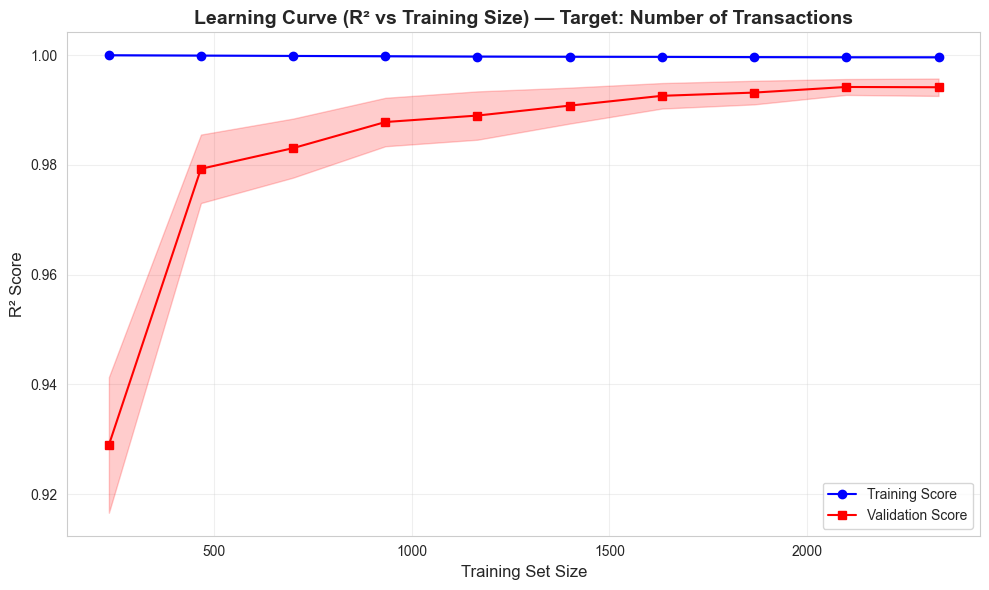

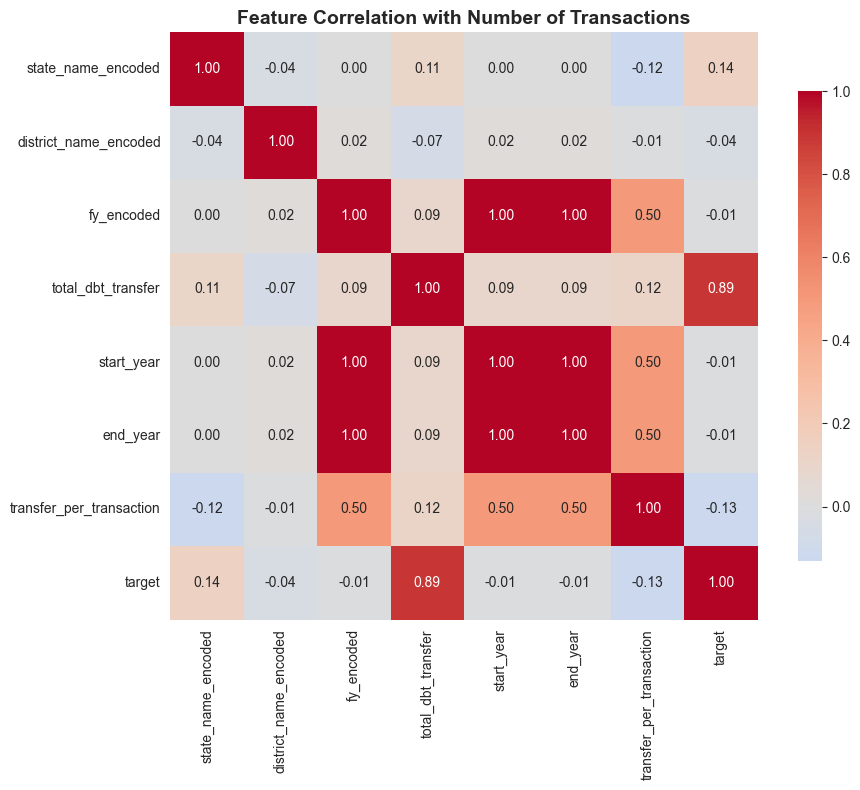

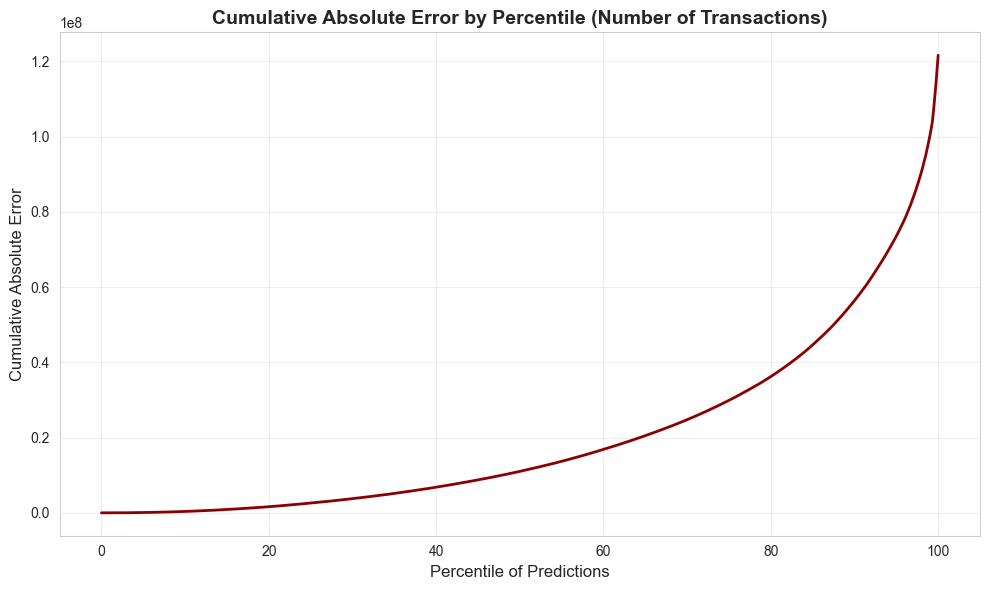

   5 visualizations saved for Model 3


In [11]:
# ==================== MODEL 3 VISUALIZATIONS ====================
print("\n[5] Generating Model 3 visualizations...")

# 1. Partial Dependence Plot (top 2 features)
top_features_idx = np.argsort(model_m3.feature_importances_)[-2:][::-1]
top_features_names = [feature_cols_m3[i] for i in top_features_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for idx, (feature_idx, feature_name) in enumerate(zip(top_features_idx, top_features_names)):
    pd_result = partial_dependence(model_m3, X_train_m3, [feature_idx], grid_resolution=50)
    axes[idx].plot(pd_result['values'][0], pd_result['average'][0], linewidth=2, color='green')
    axes[idx].set_xlabel(feature_name, fontsize=11)
    axes[idx].set_ylabel('Partial Dependence', fontsize=11)
    axes[idx].set_title(f'PDP: {feature_name}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

fig.suptitle('Partial Dependence (Top 2 Features) — Target: Number of Transactions', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 2. Prediction Error Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test_m3, y_pred_test_m3, alpha=0.5, s=50, c='purple')
ax.plot([y_test_m3.min(), y_test_m3.max()], 
        [y_test_m3.min(), y_test_m3.max()], 'r--', lw=2)
ax.set_xlabel('Actual Number of Transactions', fontsize=12)
ax.set_ylabel('Predicted Number of Transactions', fontsize=12)
ax.set_title('Actual vs Predicted (Number of Transactions)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Learning Curve Plot
train_sizes, train_scores, val_scores = learning_curve(
    model_m3, X_train_m3, y_train_m3, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                alpha=0.2, color='blue')
ax.plot(train_sizes, val_mean, label='Validation Score', color='red', marker='s')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                alpha=0.2, color='red')
ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Learning Curve (R² vs Training Size) — Target: Number of Transactions', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# 4. Feature Interaction Heatmap (correlation with target)
feature_correlations = X_train_m3.copy()
feature_correlations['target'] = y_train_m3.values
corr_matrix = feature_correlations.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation with Number of Transactions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Cumulative Error Ranking Plot
errors_m3 = np.abs(y_test_m3 - y_pred_test_m3)
sorted_errors = np.sort(errors_m3)
cumulative_errors = np.cumsum(sorted_errors)
percentiles = np.linspace(0, 100, len(sorted_errors))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(percentiles, cumulative_errors, linewidth=2, color='darkred')
ax.set_xlabel('Percentile of Predictions', fontsize=12)
ax.set_ylabel('Cumulative Absolute Error', fontsize=12)
ax.set_title('Cumulative Absolute Error by Percentile (Number of Transactions)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("   5 visualizations saved for Model 3")